# Week 05 – Federated Learning

We are using `flwr`, a package for federated learning. You can find the documentation and examples here: https://flower.ai

We use the `flwr` tutorial provided here as a basis: https://colab.research.google.com/github/adap/flower/blob/main/examples/flower-in-30-minutes/tutorial.ipynb#scrollTo=7GwQvKl3Mt-b

## set up

```
pip install pandas numpy scikit-learn matplotlib torch torchvision flwr-datasets

pip install -U flwr["simulation"]
```

If you get an error at the last step, try `pip install 'flwr[simulation]'` instead.

In [19]:
import warnings
warnings.filterwarnings("ignore")
import flwr as fl

In [20]:
from collections import OrderedDict

import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.nn.functional as F
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor

# The data

### Load dataset from `flwr_datasets`

In federated learning, each client has its own data partition. We can specify a partitioner and then pass it to the the function `FederatedDataset` from `flwr_datasets` to load the data and create n partitions of it, where n is the number of clients.

In [21]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner

# define the number of clients, i.e. number of partitions
NUM_CLIENTS = 100

# creater partitioner
partitioner = IidPartitioner(num_partitions=NUM_CLIENTS)

# partition only the "train" split of the MNIST dataset
# The MNIST dataset will be downloaded if it hasn't been already
fds = FederatedDataset(dataset="mnist", partitioners={"train": partitioner}, seed=42)

# get train and test splits
train_split = fds.load_split('train')
test_split = fds.load_split('test')

#### Q: We can use the `test_split` as centralized testset. What is the centralized testset and what is it used for?

Like the name suggests, the centralized test data is a dataset that lies at the server and allows to evaluate the global model on server side. 

#### Q: What does `NUM_CLIENTS = 100` mean?

We have 100 clients that each have their own (training) data. Each client can train the model locally and with their own data. Each client sends their model weights to the server where the models are aggregated to build the global model.

### Visualize distribution of training data 

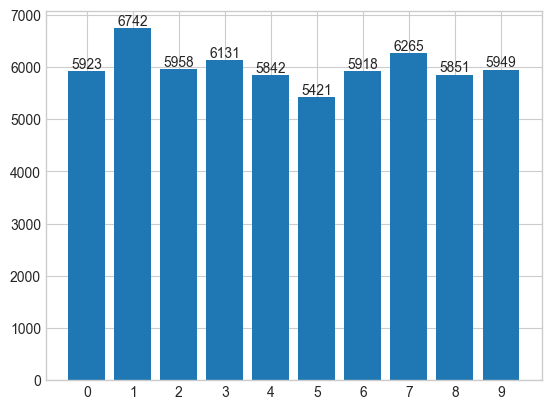

In [22]:
import matplotlib.pyplot as plt
from collections import Counter

# construct histogram
all_labels = train_split["label"]
all_label_counts = Counter(all_labels)

# visualise histogram
bar = plt.bar(all_label_counts.keys(), all_label_counts.values())
_ = plt.bar_label(bar)

# plot formatting
_ = plt.xticks([label for label in all_label_counts.keys()])

### Visualize samples from the train set

will display images with idx: [31577, 9437, 8430, 47456, 5128, 17871, 23783, 10871, 31552, 25311, 59431, 38047, 38397, 27674, 22061, 58890, 42000, 57030, 4892, 30665, 17478, 43901, 26294, 55783, 35421, 36189, 564, 53280, 33894, 22430, 50266, 16823]


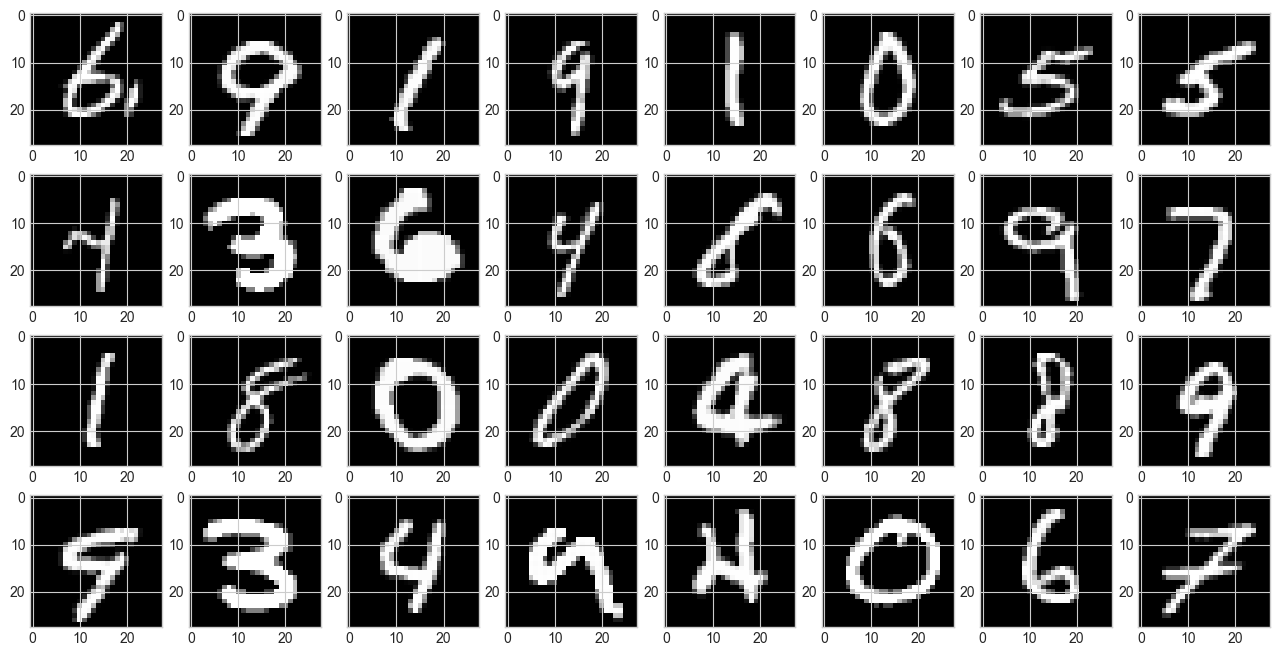

In [23]:
import random
import numpy as np
np.random.seed(42)
random.seed(42)
from PIL import Image
import io


def visualise_n_random_examples(trainset_, n: int, verbose: bool = True):
    trainset_data = [
        Image.open(io.BytesIO(entry[0].as_py())) for entry in trainset_.data[0]
    ]
    idx = list(range(len(trainset_data)))
    random.shuffle(idx)
    idx = idx[:n]
    if verbose:
        print(f"will display images with idx: {idx}")

    # construct canvas
    num_cols = 8
    num_rows = int(np.ceil(len(idx) / num_cols))
    fig, axs = plt.subplots(figsize=(16, num_rows * 2), nrows=num_rows, ncols=num_cols)

    # display images on canvas
    for c_i, i in enumerate(idx):
        axs.flat[c_i].imshow(trainset_data[i], cmap="gray")

visualise_n_random_examples(train_split, n=32)

### Plot data distribution for n partitions

In [24]:
# We could load a single partition like this
partition_0 = fds.load_partition(0)
partition_0

Dataset({
    features: ['image', 'label'],
    num_rows: 600
})

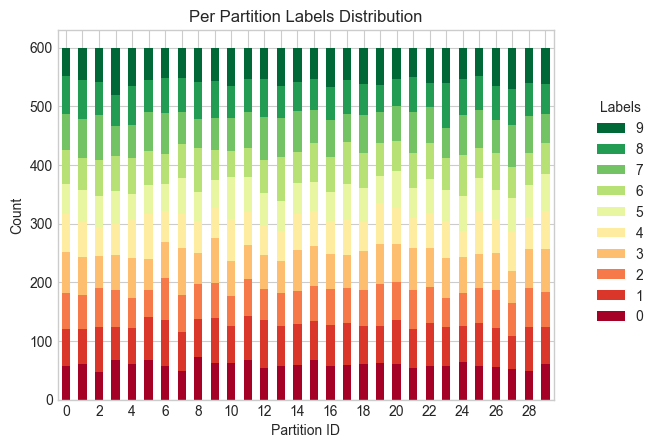

In [25]:
from flwr_datasets.visualization import plot_label_distributions

fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    max_num_partitions=30,  # nr of partitions to visualize
    title="Per Partition Labels Distribution",
)

### Define function to transform and load the data

In [26]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose

def get_mnist_dataloaders(train_set, test_set, batch_size: int):
    pytorch_transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    # Prepare transformation functions
    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    mnist_train = train_set.with_transform(apply_transforms)
    mnist_test = test_set.with_transform(apply_transforms)

    # Construct PyTorch dataloaders
    trainloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(mnist_test, batch_size=batch_size)
    return trainloader, testloader

# Construct dataloaders
trainloader, testloader = get_mnist_dataloaders(train_split, test_split, batch_size=32)


# The model

### Define the model architecture

In [27]:
class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Q: How many layers does this network have? 

7 layers: Convolutional layer (self.conv1), Max pooling layer (self.pool), Convolutional layer (self.conv2), Max pooling layer (self.pool), Fully connected layer (self.fc1), Fully connected layer (self.fc2), Fully connected layer (self.fc3)

### Define functions to train model

These functions will be needed later on by each client when they fit the model locally on their data.

In [28]:
def train(net, trainloader, optimizer, epochs, device="cpu"):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.to(device)
    net.train()
    for _ in range(epochs):
        for batch in trainloader:
            images, labels = batch["image"].to(device), batch["label"].to(device)
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()

def test(net, testloader, device):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.to(device)
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(device), batch["label"].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy


# The client

In federated learning we have multiple clients that each own some data and train a model locally with this data. 


### Defining the Flower Client 

A Flower Client is a simple Python class with two methods:

* `fit()`: With this method, the client does on-device training for a number of epochs using its own data. 

* `evaluate()`: With this method, the server can evaluate the performance of the global model on the local validation set of a client. 


In addition, we specify two helper functions:
* `set_params()`: This method takes the parameters sent by the server and uses them to initialise the parameters of the local model that is ML framework specific (e.g. TF, Pytorch, etc).

* `get_params()`: It extracts the parameters from the local model and transforms them into a list of NumPy arrays. This ML framework-agnostic representation of the model will be sent to the server.

In [29]:
from collections import OrderedDict
from typing import Dict, Tuple

from flwr.common import NDArrays, Scalar
from flwr.client import NumPyClient


class FlowerClient(NumPyClient):
    def __init__(self, trainloader, valloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.model = Net(num_classes=10)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def fit(self, parameters, config):
        """This method trains the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        set_params(self.model, parameters)

        # read from config
        lr, epochs = config["lr"], config["epochs"]

        # Define the optimizer
        optim = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)

        # do local training (call same function as centralised setting)
        train(self.model, self.trainloader, optim, epochs, self.device)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return get_params(self.model), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        set_params(self.model, parameters)
        # do local evaluation (call same function as centralised setting)
        loss, accuracy = test(self.model, self.valloader, self.device)
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy}

# Two auxhiliary functions to set and extract parameters of a model
def set_params(model, parameters):
    """Replace model parameters with those passed as `parameters`."""

    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.from_numpy(v) for k, v in params_dict})
    # now replace the parameters
    model.load_state_dict(state_dict, strict=True)


def get_params(model):
    """Extract model parameters as a list of NumPy arrays."""
    return [val.cpu().numpy() for _, val in model.state_dict().items()]


### Assigning partition of the data to a client

Each client has it's own partition of the data. We already specified in the beginning the nr of partitions we need. With this function we can load the partitions and assign them to a client. We also make use of the dataloaders we defined in the beginning to correctly load and transform the data.

In [30]:
from flwr.common import Context
from flwr.client import ClientApp

def client_fn(context: Context):
    """Returns a FlowerClient containing its data partition."""

    partition_id = int(context.node_config["partition-id"])
    partition = fds.load_partition(partition_id, "train")
    # partition into train/validation
    partition_train_val = partition.train_test_split(test_size=0.1, seed=42)
    trainset = partition_train_val["train"] 
    valset = partition_train_val["test"]

    # Let's use the function defined earlier to construct the dataloaders
    # and apply the dataset transformations
    trainloader, testloader = get_mnist_dataloaders(trainset, valset, batch_size=32)

    return FlowerClient(trainloader=trainloader, valloader=testloader).to_client()


# Concstruct the ClientApp passing the client generation function
client_app = ClientApp(client_fn=client_fn)

## Aggregation strategy – Federated Averaging


The core steps of federated learning are sampling clients, sending the global model to the clients so they can run `fit()` locally on their training data, receive updated models from each client, aggregate these models to construct a new global model, evaluate model.

There are different ways to aggregate all the model updates received from the clients. The probably most well-known is _federated averaging_, see the paper by [McMahan et al. (2016)](https://arxiv.org/abs/1602.05629) for more details.

We need to define the strategy used for aggregation in `flwr`.


### Function to evaluate on centralized test set

In [31]:
def get_evaluate_fn(testloader):
    """Return a function that can be called to do global evaluation. In other words, this function will
    be executed by the strategy at the end of each round to evaluate the state of the global model."""

    # Evaluate global model on the whole test set
    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate a model and replace its 
        parameters with those from the global model. Then, the model will be evaluate on the test
        set (recall this is the whole MNIST test set)."""

        model = Net(num_classes=10)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # call test (evaluate model as in centralised setting)
        loss, accuracy = test(model, testloader, device)
        return loss, {"accuracy": accuracy}

    return evaluate_fn

### Extra functionality

We are writing two functions – (1) `fit_config()` where we can configure how clients do local training (we can specify nr of epochs, learning rate, etc.), and (2) `weighted_average()` which aggregates the performance metrics (accuracy in this case) that the clients return.

In [33]:
from typing import List
from flwr.common import Metrics

def fit_config(server_round: int) -> Dict[str, Scalar]:
    """Return a configuration with static batch size and (local) epochs."""
    config = {
        "epochs": 1,  # Number of local epochs done by clients
        "lr": 0.01,  # Learning rate to use by clients during fit()
    }
    return config

# Define metric aggregation function
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

We'll use these functions when defining the strategy in the next section.

### The `server_fn` callback

The easiest way to create a `ServerApp` with the aggregation _strategy_ of your choice is by means of a `server_fn` callback. It has a similar signature to `client_fn` but, instead of returning a client object, it returns all the components needed to run the server-side logic in Flower. Inside `server_fn` we'll define the strategy.

In [34]:
from flwr.common import ndarrays_to_parameters
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg

# let's run the simulation for 10 rounds
num_rounds = 20

def server_fn(context: Context):

    # instantiate the model
    model = Net(num_classes=10)
    ndarrays = get_params(model)
    # convert model parameters to flwr.common.Parameters
    global_model_init = ndarrays_to_parameters(ndarrays)

    # Define the strategy
    strategy = FedAvg(
        # num_rounds=num_rounds,
        fraction_fit=0.1,  # 10% clients sampled each round to do fit()
        fraction_evaluate=0.05,  # 5% clients sample each round to do evaluate()
        on_fit_config_fn=fit_config, # configuration for clients
        evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics using weighted average as defined earlier
        initial_parameters=global_model_init,  # initialised global model
        evaluate_fn=get_evaluate_fn(testloader),  # gloabl evaluation on centralized test set
    )

    # Construct ServerConfig
    config = ServerConfig(num_rounds=num_rounds)

    # Wrap everything into a `ServerAppComponents` object
    return ServerAppComponents(strategy=strategy, config=config)

# Create your ServerApp
server_app = ServerApp(server_fn=server_fn)

# Run simulation

In [16]:
from flwr.simulation import run_simulation

run_simulation(
    server_app=server_app, 
    client_app=client_app, 
    num_supernodes=NUM_CLIENTS
)

INFO :      Starting Flower ServerApp, config: num_rounds=20, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 721.0719521045685, {'accuracy': 0.1102}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 714.2775464057922, {'accuracy': 0.246}, 6.0277205419843085)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 100)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 100)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (2, 703.4319036006927, {'accuracy': 0.2826}, 8.749051125021651)
INFO :      configure

# Evaluation

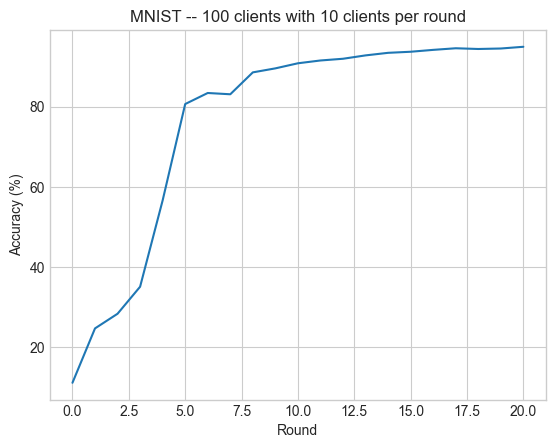

In [35]:
# copy/paste from printed output
results_centralized = {'accuracy': [(0, 0.1102),
(1, 0.246),
(2, 0.2826),
(3, 0.3501),
(4, 0.5657),
(5, 0.8063),
(6, 0.8339),
(7, 0.8307),
(8, 0.8854),
(9, 0.8954),
(10, 0.9081),
(11, 0.9151),
(12, 0.9194),
(13, 0.9278),
(14, 0.9342),
(15, 0.9369),
(16, 0.9416),
(17, 0.9456),
(18, 0.9438),
(19, 0.945),
(20, 0.9493)]}

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

# Extract rounds and accuracy values
rounds_centralized = [item[0] for item in results_centralized['accuracy']]
global_accuracy_centralised = [item[1] for item in results_centralized['accuracy']]

# plot centralized accuracy scores
acc = [100.0 * data for data in global_accuracy_centralised] # scores
plt.plot(rounds_centralized, acc)

# axis labels & title
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title(f"MNIST -- {NUM_CLIENTS} clients with 10 clients per round")
plt.show()

#### Q: Explain what can be seen in the plot. 

The plot visualizes the accuracy of the model on the centralized test set (so this is centralized evaluation) by round. We ran the simulation per round, where each round some clients train their model and the global model is updated. As we would expect, the model improves with each round and the improvement is less steep in later rounds as the model will eventually converge on the weights. The accuracy of the final model is around 94%, where it also seems to converge. If we would run it for more rounds we could make a better judgement of where is really converges.